In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys,warnings,random

import rasterio as rs
from rasterio.windows import Window,from_bounds
import geopandas as gpd

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[2:4], 'GPU')
logical_gpus = tf.config.list_logical_devices('GPU')
print(f'{len(gpus)}: Physical GPUs, {len(logical_gpus)}: Logical GPUs')

4: Physical GPUs, 2: Logical GPUs


In [4]:
class fetch_geom_batch(keras.utils.Sequence):
    
    def __init__(self,patches_path:str,feature_image_path:str, label_image_path:str, label:str, img_size:tuple, batch_size:int):
        
        self.patches_path = patches_path
        self.feature_image_path = feature_image_path
        self.label_image_path = label_image_path
        self.label = label
        self.batch_size = batch_size
        self.img_size = img_size
        
        self.patches = gpd.read_file(self.patches_path)
        self.patches_label = self.patches[self.patches['label'] == self.label]
        self.patches_label_shuffle = self.patches_label.sample(frac=1)
        
        
    def __len__(self):
        return len(self.patches_label) // self.batch_size
    
    def __getitem__(self,idx):
        
        i = idx * self.batch_size
        geom_patch_batch = self.patches_label_shuffle.iloc[i : i + self.batch_size]
        
        
        feat_img = rs.open(self.feature_image_path)
        label_img = rs.open(self.label_image_path)

        image = np.zeros((self.batch_size,) + self.img_size + (9,), dtype="float32") # number of channel should be changed
        label = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        
        for j, i in enumerate(range(len(geom_patch_batch))):
            minx,miny,maxx,maxy = geom_patch_batch.iloc[i, 3].bounds # Geometry column should be selected
            window_f = from_bounds(minx, miny, maxx, maxy, transform=feat_img.transform)
            window_l = from_bounds(minx, miny, maxx, maxy, transform=label_img.transform)
            transform = rs.transform.from_bounds(minx,miny,maxx,maxy, self.img_size[0], self.img_size[1])
            img_feat = np.moveaxis(feat_img.read(window=window_f,out_shape=self.img_size,resampling=0),0,2)
            img_label = np.moveaxis(label_img.read(window=window_l,out_shape=self.img_size,resampling=0),0,2)
            image[j] = img_feat
            label[j] = img_label
        
        return image, label

In [5]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

In [51]:
# Constants
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SHAPE = (64, 64)
patches_path = './processed_DATA/patches_train_test_validation.geojson'
feature_image_path = "./processed_DATA/features.tif"
label_image_path = "./processed_DATA/binrized_image.tif"

In [52]:
# filepath="./model/v1/weights-improvement-{epoch:02d}-{val_custom_f1:.2f}.hdf5" #File name includes epoch and validation accuracy.
# checkpoint = ModelCheckpoint(filepath, monitor='val_jacard_coef', verbose=1, save_best_only=True, mode='max')

# callbacks = [EarlyStopping(patience=20, monitor="val_custom_f1"),checkpoint]

In [53]:
TRAINING_DATA = fetch_geom_batch(patches_path,feature_image_path,label_image_path,label='train',img_size=IMAGE_SHAPE,batch_size=BATCH_SIZE)
VALID_DATA = fetch_geom_batch(patches_path,feature_image_path,label_image_path,label='validation',img_size=IMAGE_SHAPE,batch_size=BATCH_SIZE)
TEST_DATA = fetch_geom_batch(patches_path,feature_image_path,label_image_path,label='test',img_size=IMAGE_SHAPE,batch_size=BATCH_SIZE)

In [54]:
def build_model(metrics: list,loss_function):
    inputs = tf.keras.layers.Input(shape=(64, 64, 9))
    
    # Encoder
    c1 = BatchNormalization(name='Norm1')(inputs)
    c1 = Conv2D(filters=16,kernel_size=(3,3),padding='valid', kernel_initializer='he_normal', activation='relu', name='Conv1_1')(c1)
    c1 = Conv2D(filters=32,kernel_size=(3,3),padding='valid', kernel_initializer='he_normal', activation='relu', name='Conv1_2')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = BatchNormalization(name='Norm2')(p1)
    c2 = Conv2D(filters=64,kernel_size=(3,3),padding='valid', kernel_initializer='he_normal', activation='relu', name='Conv2_1')(c2)
    c2 = Conv2D(filters=32,kernel_size=(3,3),padding='valid', kernel_initializer='he_normal', activation='relu', name='Conv2_2')(c2)
    
    u2 = UpSampling2D((2,2), name="up_dm1")(c2)
    u2 = concatenate([u2, Cropping2D(4)(c1)])
    c3 = Conv2D(filters=32,kernel_size=(3,3),padding='valid', kernel_initializer='he_normal', activation='relu', name='Conv3_1')(u2)
    c3 = Conv2D(filters=16,kernel_size=(3,3),padding='valid', kernel_initializer='he_normal', activation='relu', name='Conv3_2')(c3)
    
    output = keras.layers.Conv2D(filters=1,kernel_size=(3,3),padding='same', kernel_initializer='he_normal', activation='sigmoid', name='OutImage')(c3)
    model = tf.keras.Model(inputs, output,name='SARCNN')
    
    model.compile(optimizer='adam',
              loss= loss_function,
              metrics=metrics)
    return model


def run_model(metrics,loss):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = build_model(metrics,loss)

    model_history = model.fit(TRAINING_DATA, epochs=EPOCHS,
                              validation_data=VALID_DATA,
                              use_multiprocessing=True,
                              workers=16,
                              max_queue_size=32)
    
    return model, model_history

In [55]:
model,model_history = run_model(metrics=[jacard_coef,'accuracy'],loss= 'binary_crossentropy')

Epoch 1/10
365/365 [==============================] - 36s 86ms/step - loss: 0.2449 - jacard_coef: 0.1744 - accuracy: 0.9261 - val_loss: 0.3132 - val_jacard_coef: 0.0130 - val_accuracy: 0.9481
Epoch 2/10
365/365 [==============================] - 33s 81ms/step - loss: 0.1915 - jacard_coef: 0.2448 - accuracy: 0.9359 - val_loss: 0.1681 - val_jacard_coef: 0.1023 - val_accuracy: 0.9487
Epoch 3/10
365/365 [==============================] - 34s 83ms/step - loss: 0.1807 - jacard_coef: 0.2675 - accuracy: 0.9385 - val_loss: 0.2273 - val_jacard_coef: 0.0855 - val_accuracy: 0.9169
Epoch 4/10
365/365 [==============================] - 34s 84ms/step - loss: 0.1736 - jacard_coef: 0.2844 - accuracy: 0.9404 - val_loss: 0.1684 - val_jacard_coef: 0.0869 - val_accuracy: 0.9496
Epoch 5/10
365/365 [==============================] - 34s 83ms/step - loss: 0.1695 - jacard_coef: 0.2960 - accuracy: 0.9418 - val_loss: 0.1855 - val_jacard_coef: 0.0878 - val_accuracy: 0.9496
Epoch 6/10
365/365 [====================

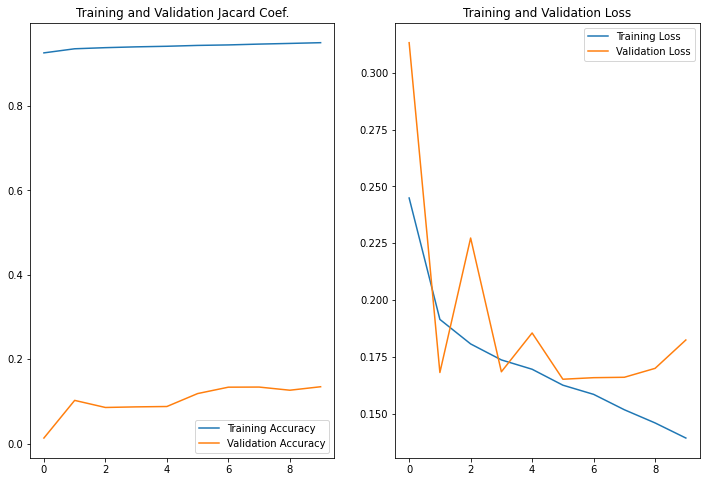

In [56]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_jacard_coef']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Jacard Coef.')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.savefig('./foo.png')
plt.show()

In [1]:
!ls ./model/v1

weights-improvement-01-0.09.hdf5  weights-improvement-04-0.14.hdf5
weights-improvement-02-0.10.hdf5  weights-improvement-05-0.13.hdf5
weights-improvement-03-0.12.hdf5  weights-improvement-06-0.13.hdf5
weights-improvement-04-0.12.hdf5  weights-improvement-06-0.14.hdf5
weights-improvement-04-0.13.hdf5


In [32]:
model.evaluate(TEST_DATA)

201/201 [==============================] - 61s 301ms/step - loss: 0.2095 - jacard_coef: 0.1896 - accuracy: 0.9297


[0.2094995677471161, 0.1895698606967926, 0.9297058582305908]

In [57]:
randomlist = random.sample(range(0, 201), 30)

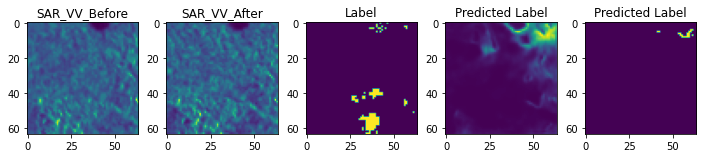

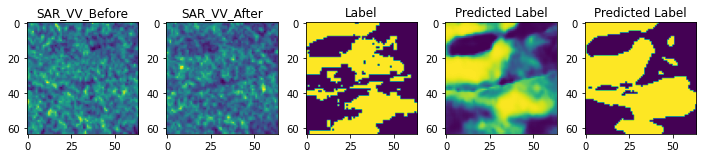

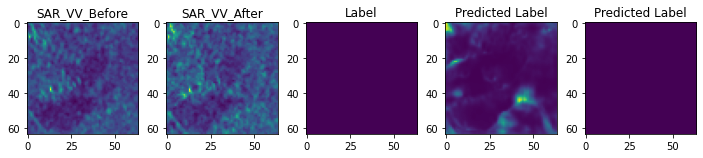

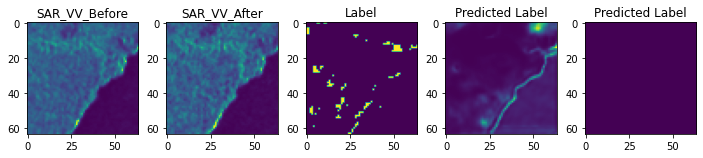

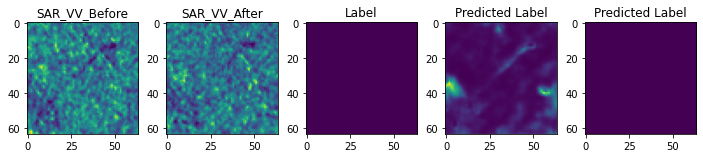

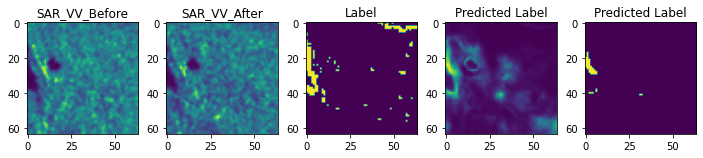

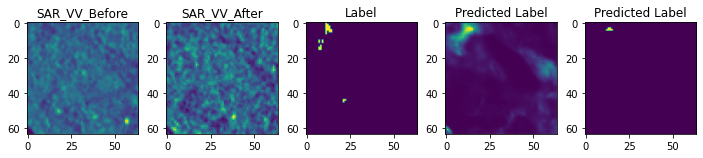

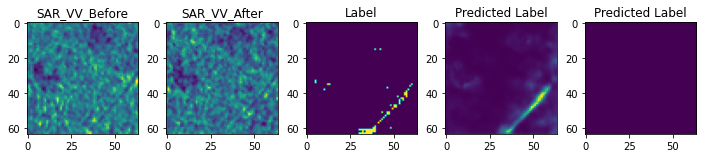

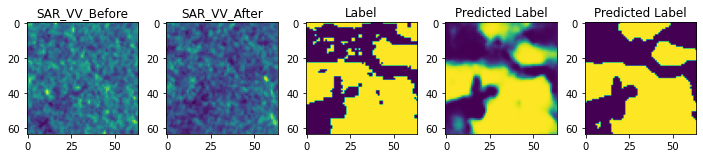

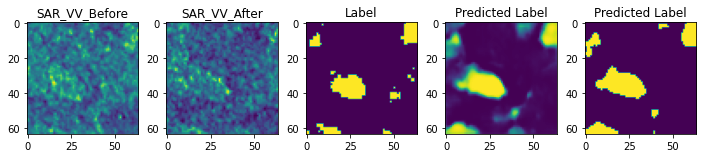

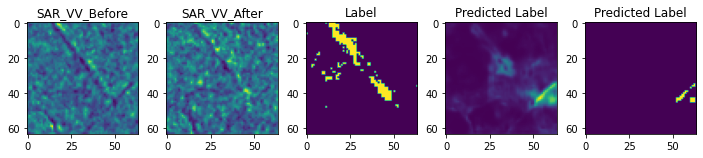

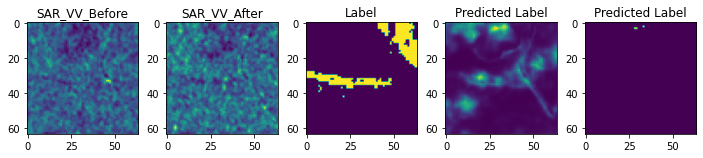

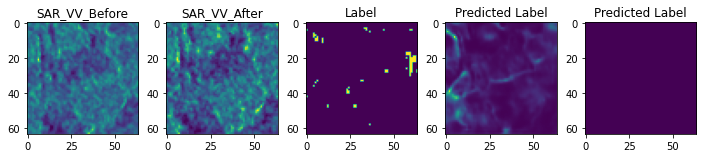

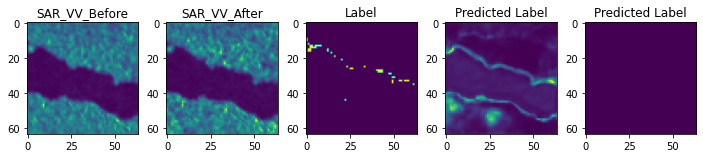

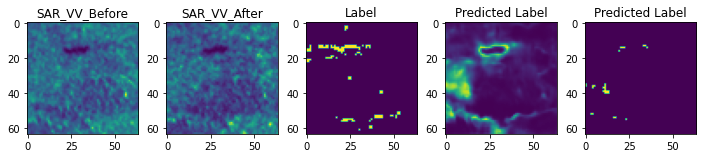

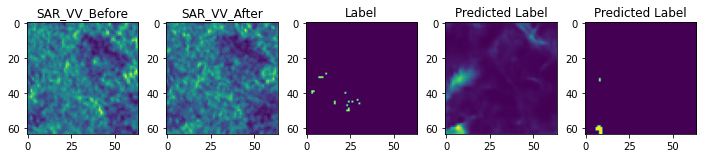

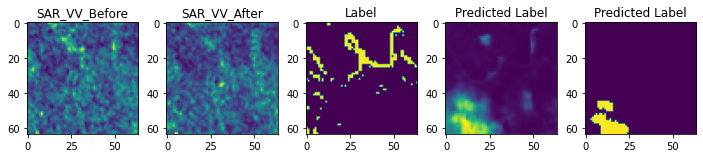

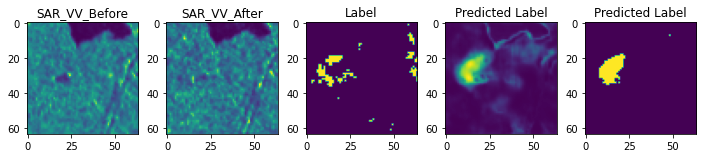

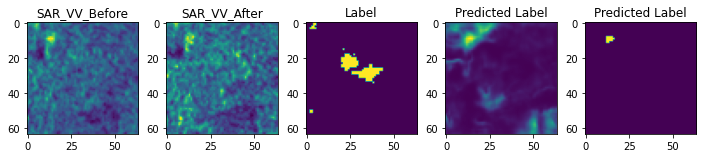

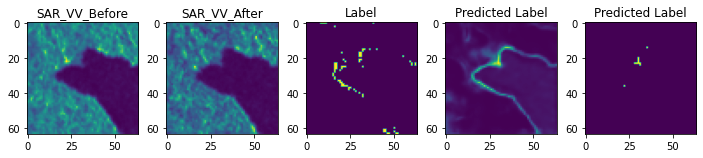

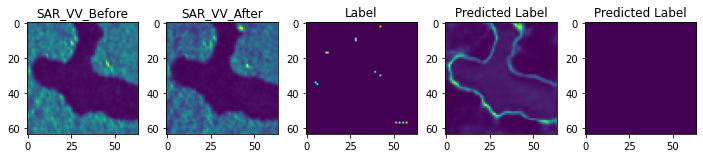

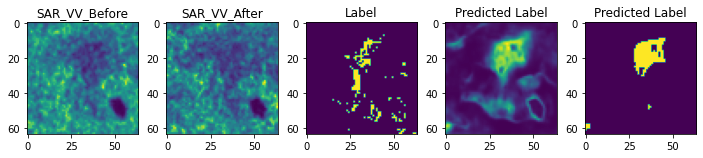

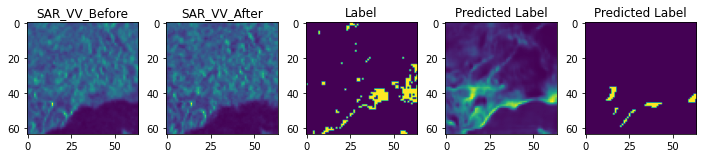

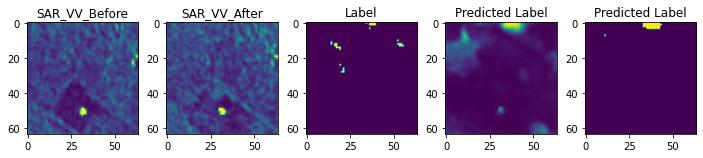

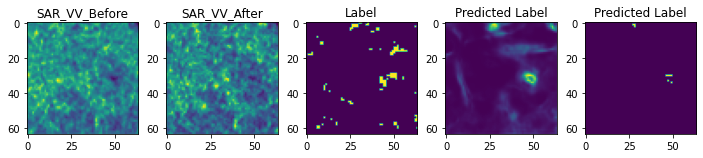

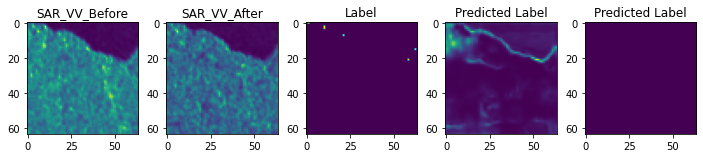

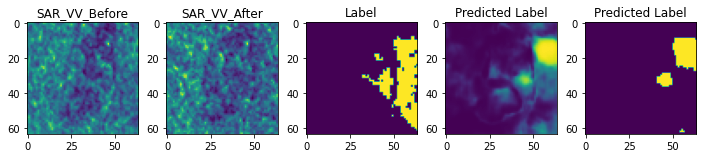

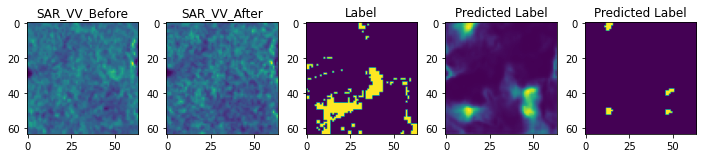

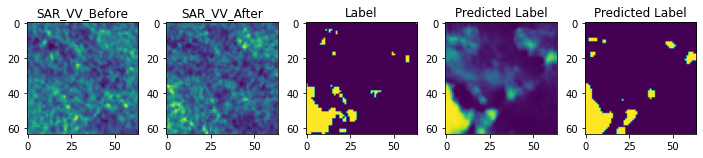

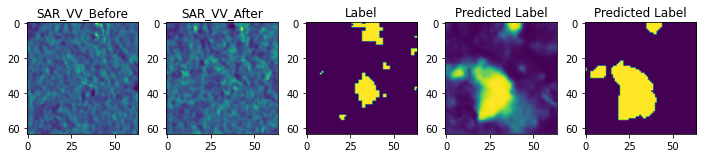

In [58]:
for i in randomlist:
    fig = plt.figure(1, figsize=([12, 12]))
    gs = plt.GridSpec(1,5, wspace=0.25, hspace=0.25)

    img_id = i
    feat, label = TEST_DATA[img_id]

    # Panel 01
    xtr_subsplot= fig.add_subplot(gs[:,:1])
    plt.imshow(feat[10,...,0])
    plt.title('SAR_VV_Before')

    # Panel 02
    xtr_subsplot= fig.add_subplot(gs[:,1:2])
    plt.imshow(feat[10,...,2])
    plt.title('SAR_VV_After')

    # Panel 03
    xtr_subsplot= fig.add_subplot(gs[:,2:3])
    plt.imshow(label[10,...,0])
    plt.title('Label')

    # Panel 04
    xtr_subsplot= fig.add_subplot(gs[:,3:4])
    plt.imshow(model.predict(feat[10,...].reshape(1,64,64,9))[0,...])
    plt.title('Predicted Label')
    
    # Panel 04
    xtr_subsplot= fig.add_subplot(gs[:,4:])
    plt.imshow(np.where(model.predict(feat[10,...].reshape(1,64,64,9))[0,...]>0.5,1,0))
    plt.title('Predicted Label')


    plt.show()